# Intro in PyTorch, DevOps, R&D in Deep Learning

In this workshop, we will introduce pytorch using the classification problem as an example.

## CIFAR10 and PyTorch

In [2]:
from itertools import islice # useful for slicing pytorch DataLoader objects

from matplotlib import pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms

from torch import nn
import torch.nn.functional as F

import torch.optim as optim

One of the important components of the neural network training pipeline is data.
     There are several stages in pytorch, depending on the task. In this case, we have
     image preprocessing in the form of `transform`, reading of images`torchvision.datasets.CIFAR10` and assembly
     images in batch `torch.utils.data.DataLoader`. 

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                               shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                              shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's look at one batch of images 

In [3]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

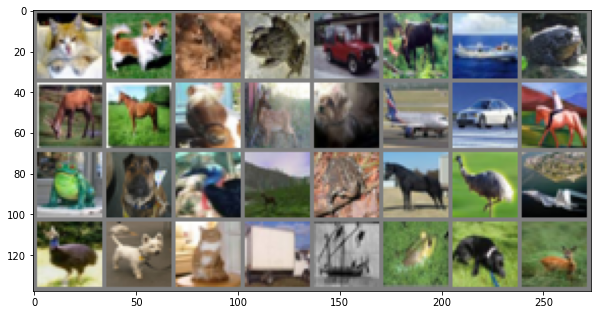

In [4]:
images, _ = list(islice(train_dataloader, 1))[0]

plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(images))

The next component is the model itself. For example, just take the network from the tutorials. 

In [5]:
from torch import nn
import torch.nn.functional as F


class Reshape(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        # X.shape == [B, C, H, W] -> [B, H']
        return torch.flatten(x, start_dim=1)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            Reshape(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(True),
            nn.Linear(120, 84),
            nn.ReLU(True),
            nn.Linear(84, 10),
        )
        
    def forward(self, x):
        return self.net(x)


net = Net()
device = torch.device('cpu')
net = net.to(device)
net = net.train()

Determine the loss function and optimization method.

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,
                      nesterov=True, weight_decay=1e-5)

And the last component of the pipeline is writing train / val loops. In this case, everything is simple, but
     in large tasks, this part takes a lot of time and code :( It is worth taking a closer look at the libraries that
     they do it for us, for example, pytorch-lighting

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


Let's see the quality of the classification on one test batch 

In [8]:
images, _ = list(islice(test_dataloader, 1))[0]

with torch.no_grad():
    logits = net(images)
    predicted_labels = torch.argmax(logits, dim=1)

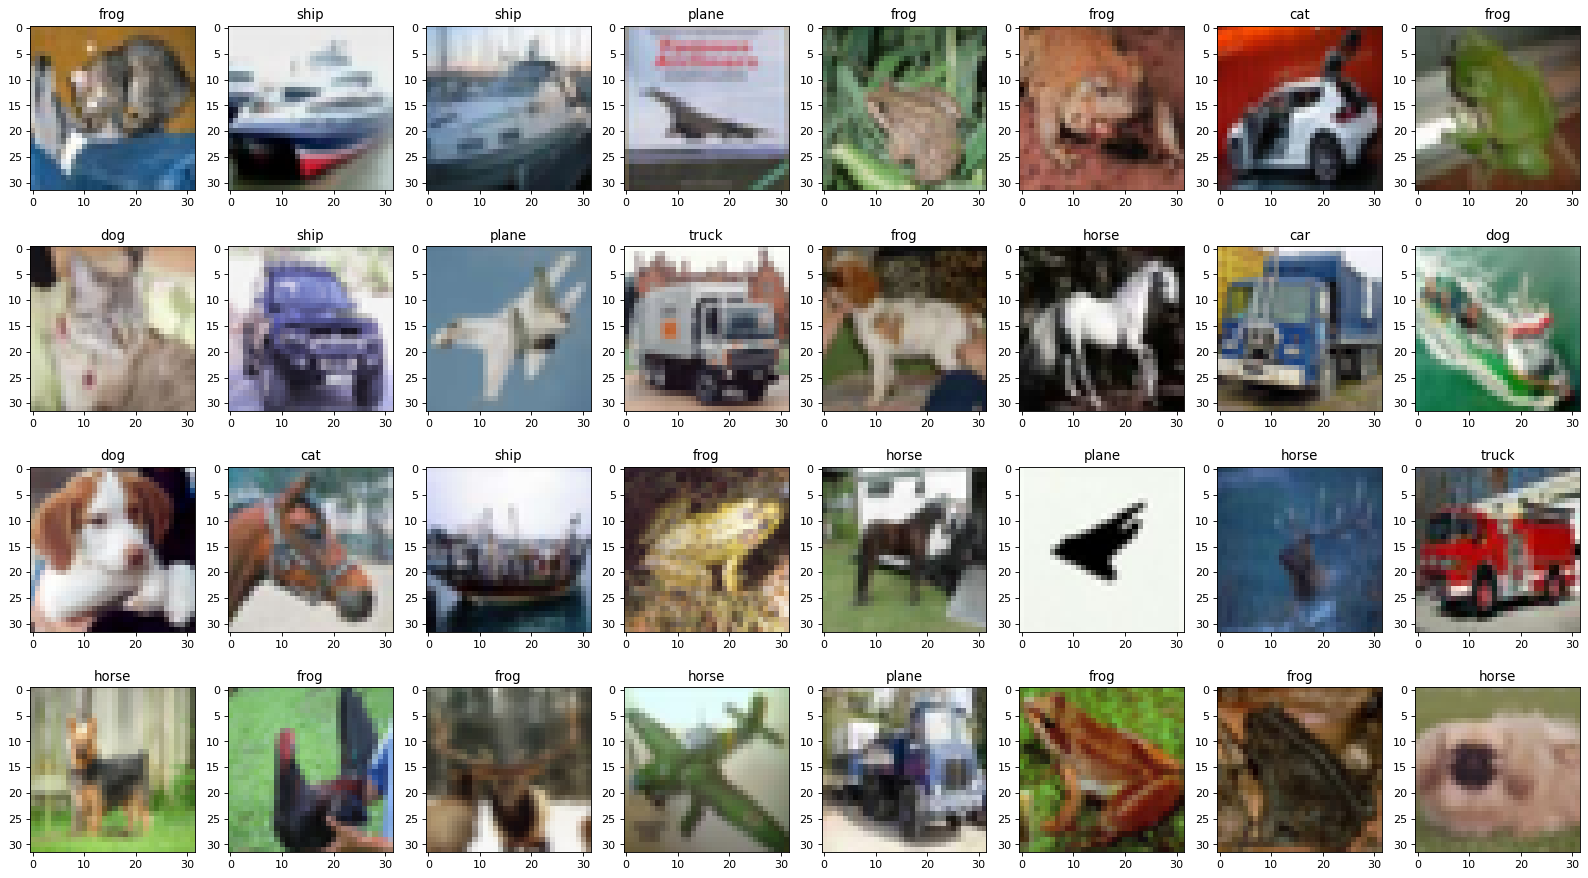

In [9]:
_, axes = plt.subplots(4, 8, figsize=(25, 14), dpi=80)
axes = axes.flatten()

for ax, image, label in zip(axes, images, predicted_labels):
    image = image / 2 + 0.5
    image = image.permute(1, 2, 0)
    
    ax.set_title(classes[label.item()])
    ax.imshow(image)
    
plt.show()

# torchaudio

Let's get acquainted a little with torchaudio - analogue of torchvision, but for sound. torchaudio provides the ability to read
     STFT (short-time Fourier transform), Spectrograms, MelSpectrograms, and much more. 

In [10]:
import torchaudio
from scipy.signal import hann
from scipy.io import wavfile

C:\Users\Mark\Miniconda3\envs\dla\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


We read the wav file and see how it looks 

In [11]:
filename = "audio.wav"
waveform, sample_rate = torchaudio.load(filename)

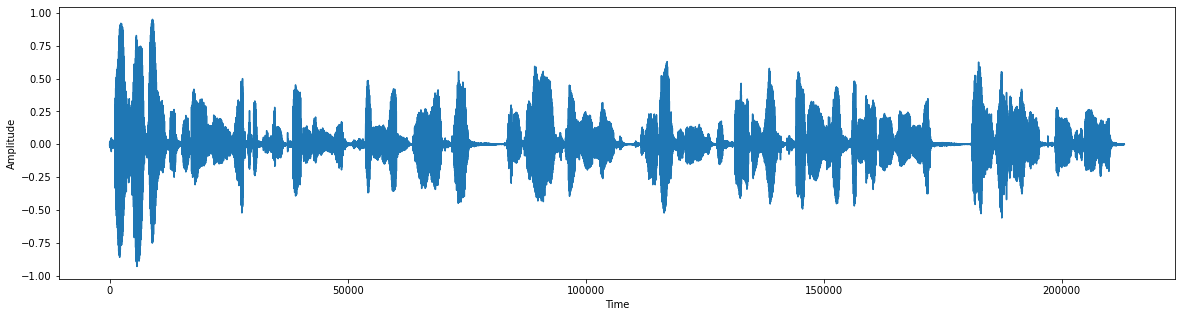

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(waveform.squeeze())
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Short-time Fourier transform

Let's look at the STFT from the box. Let's remember that STFT is cutting audio into windows with some step,
     using a window function, and then applying a Fourier transform. 

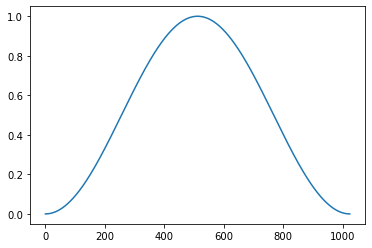

In [15]:
window = hann(1024)
plt.plot(window)
plt.show()

In [ ]:
freqs = torch.stft(
    input=waveform,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    window=torch.from_numpy(window),
    center=False
)

To get rid of the complex plane, we take the norm (p == 2) in the last dimension. 

In [17]:
freqs = torch.stft(
    input=waveform,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    window=torch.from_numpy(window),
    center=False
)

In [18]:
spectrograms = torch.norm(freqs, 2, -1)

If you look closely, you can see white spots. 

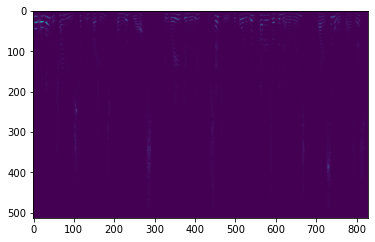

In [19]:
plt.imshow(spectrograms.squeeze())

# Spectrograms



Shape of spectrogram: torch.Size([1, 513, 833])


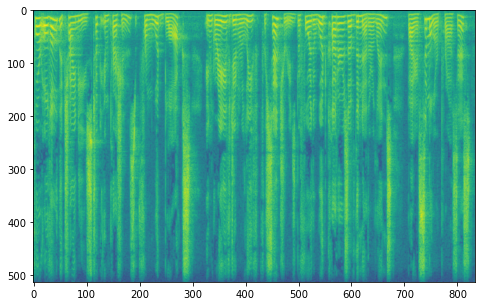

In [20]:
spectrogramer = torchaudio.transforms.Spectrogram(
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    power=2.0,
)

spectrogram = spectrogramer(waveform)

print("Shape of spectrogram: {}".format(spectrogram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(np.log(spectrogram.squeeze()))
plt.show()

# MelSpectrograms

Shape of spectrogram: torch.Size([1, 80, 833])


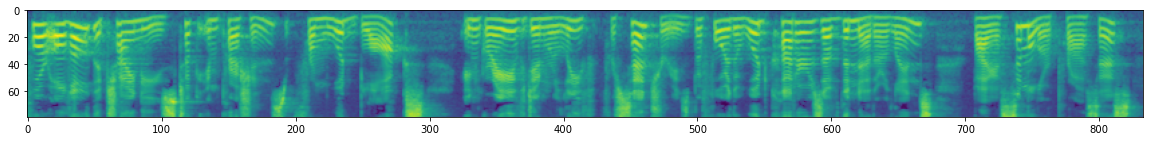

In [21]:
mel_spectrogramer = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    f_min=0,
    f_max=8000,
    n_mels=80,
)

mel_spectrogram = mel_spectrogramer(waveform)

print("Shape of spectrogram: {}".format(mel_spectrogram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(torch.log(mel_spectrogram.squeeze()))
plt.show()